
<div align="center">

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dapivei/causal-infere/blob/main/sections/6_Regression_1-2.ipynb)

</div>


$$
\begin{array}{c}
\textbf{INTRODUCTION TO CAUSAL INFERENCE}\\\\\\\\
\textbf{Daniela Pinto Veizaga, Xiang Pan, and Xiang Gao} \\
\textit{Center for Data Science, New York University} \\\\\\
\end{array}
$$
---

$$
\begin{array}{c}
\textbf{Week 6: Regression}
\end{array}
$$

**Table of contents**<a id='toc0_'></a>    
- [Descriptive Regression](#toc1_)    
- [Vectorized implementation for linear regression](#toc2_)    
- [Kernel Regression](#toc3_)    
- [Causal Regression](#toc4_)    
  - [Identification](#toc4_1_)    
- [Experiments](#toc5_)    
  - [Regression Standard Errors](#toc5_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Descriptive Regression](#toc0_)

\begin{align}
Y=\beta_0+\beta_1 X+\varepsilon
\end{align}

\begin{align}
\min _{b_0, b_1} E\left[\left(Y-\left(b_0+b_1 X\right)\right)^2\right]
\end{align}

Residual:
\begin{align}
\varepsilon \equiv Y-\left(\beta_0+\beta_1 X\right)
\end{align}

\begin{align}
\begin{aligned}
& Y=X^2 \\
& \beta_0+\beta_1 X=1
\end{aligned}
\end{align}

In [22]:
# Target function
def g(x):
    return x**2

# Modeling function
def f(x, beta_0, beta_1):
    return beta_0 + beta_1 * x

# Loss function
def loss(y, y_pred):
    return (y - y_pred)**2

# Closed-form solution
def closed_form_solution(x, y):
    beta_1 = (y.dot(x) - y.mean() * x.mean()) / ((x - x.mean())**2).sum()
    beta_0 = y.mean() - beta_1 * x.mean()
    return beta_0, beta_1

# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider

# Function to update plot with boundaries
def update_plot(left_boundary, right_boundary, gap):
    # Generate data points within the specified boundary
    # x = np.linspace(left_boundary, right_boundary, gap)
    x = np.arange(left_boundary, right_boundary, gap)
    y = g(x)

    # Get closed-form solution for beta_0 and beta_1
    beta_0, beta_1 = closed_form_solution(x, y)

    # Calculate the predicted values
    y_pred = f(x, beta_0, beta_1)

    # Plot the target and modeling functions
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label='Target Function (g(x))')
    plt.plot(x, y_pred, label=f'Modeling Function (f(x, beta_0={beta_0:.2f}, beta_1={beta_1:.2f}))')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.text(10, 10, f'f(x) = {beta_0:.2f} + {beta_1:.2f}x', fontsize=12, color='red')
    plt.text(0, 0, f'f(x) = x^2', fontsize=12, color='blue')
    plt.title('Target vs. Modeling Function')
    plt.grid(True)
    plt.show()

# Interactive sliders for setting boundaries
interact(update_plot,
         left_boundary=FloatSlider(min=-20, max=0, step=1, value=-10, description='Left Boundary'),
         right_boundary=FloatSlider(min=0, max=30, step=1, value=20, description='Right Boundary'),
         gap=FloatSlider(min=0.1, max=20, step=0.1, value=1, description='Gap'))



interactive(children=(FloatSlider(value=-10.0, description='Left Boundary', max=0.0, min=-20.0, step=1.0), Flo…

<function __main__.update_plot(left_boundary, right_boundary, gap)>

# <a id='toc2_'></a>[Vectorized implementation for linear regression](#toc0_)

## Convert a LR with bias to a LR without bias

\begin{align}
Y = \beta_0 + \beta_1 X + \varepsilon
\end{align}

\begin{align}
\boldsymbol{\beta}=\left[\begin{array}{c}
\beta_0 \\
\beta_1 \\
\vdots \\
\beta_d
\end{array}\right] \quad \boldsymbol{x}^{\boldsymbol{\top}}=\left[\begin{array}{llll}
1 & x_1 & \ldots & x_d
\end{array}\right]
\end{align}

\begin{align}
Y = \mathbb{x}^{\top} \mathbb{\beta} + \varepsilon
\end{align}



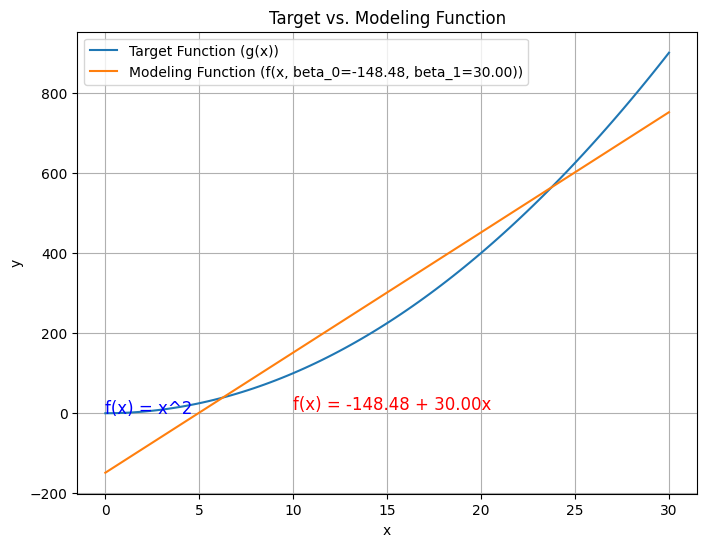

In [17]:
# concat the beta_0 and beta_1 as a vector
# beta = np.array([beta_0, beta_1])

# vectorized implementation for linear regression
def vectorized_linear_regression(x, y):
    X = np.vstack([np.ones(len(x)), x]).T
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return beta


# redo the plot with vectorized implementation
x = np.linspace(0, 30, 100)
y = g(x)
beta = vectorized_linear_regression(x, y)
y_pred = f(x, beta[0], beta[1])

plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Target Function (g(x))')
plt.plot(x, y_pred, label=f'Modeling Function (f(x, beta_0={beta[0]:.2f}, beta_1={beta[1]:.2f}))')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.text(10, 10, f'f(x) = {beta[0]:.2f} + {beta[1]:.2f}x', fontsize=12, color='red')
plt.text(0, 0, f'f(x) = x^2', fontsize=12, color='blue')
plt.title('Target vs. Modeling Function')
plt.grid(True)



# <a id='toc3_'></a>[Kernel Regression](#toc0_)

If we know there is a non-linear relationship between X and Y, can we first map X to higher dimension 'components' and then apply linear regression?


In [33]:
from ipywidgets import FloatSlider, IntSlider

# If we know
# Polynomial kernel
def polynomial_kernel(x, degree):
    return np.array([x**i for i in range(1, degree+1)]).T


# Kernel Ridge Regression
def kernel_ridge_regression(x, y, alpha, degree):
    X = polynomial_kernel(x, degree)
    print(X.shape)
    beta = np.linalg.inv(X.T.dot(X) + alpha * np.eye(X.shape[1])).dot(X.T).dot(y)
    return beta

def kernel_f(x, beta):
    return np.dot(polynomial_kernel(x, len(beta)), beta)

def update_plot_kernel_ridge_regression(alpha, degree):
    x = np.linspace(0, 30, 100)
    y = g(x)
    beta = kernel_ridge_regression(x, y, alpha, degree)
    print(beta)
    y_pred = kernel_f(x, beta)
    mse = ((y - y_pred)**2).mean()
    print(mse)

    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label='Target Function (g(x))')
    plt.plot(x, y_pred, label=f'Modeling Function (f(x, beta={beta}))', linestyle='--')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.text(10, 10, f'f(x) = {beta[0]:.2f} + {beta[1]:.2f}x', fontsize=12, color='red')
    plt.text(0, 0, f'f(x) = x^2', fontsize=12, color='blue')
    plt.title('Target vs. Modeling Function')
    plt.grid(True)
    plt.show()
interact(update_plot_kernel_ridge_regression,
         alpha=FloatSlider(min=0, max=1, step=0.1, value=0.1, description='Alpha'),
         degree=IntSlider(min=1, max=10, step=1, value=3, description='Degree'))


interactive(children=(FloatSlider(value=0.1, description='Alpha', max=1.0), IntSlider(value=3, description='De…

<function __main__.update_plot_kernel_ridge_regression(alpha, degree)>

Side Note:

What neural network did? Map the input $X$ to a higher dimension representation $\phi(X)$, and then apply linear classifier/regressor.

# <a id='toc4_'></a>[Causal Regression](#toc0_)

If we assume the linear all-cause model,
\begin{align}
    Y (S, U) = \alpha_0 + \alpha_1 S +U
\end{align}

The causal residual is U. For causal interpretation, $\mathbb{E}[U] = 0$.

If,

\begin{align}
    E (U) \neq 0
\end{align}


we redefine the 

\begin{align}
    & Y (S, U) \\
    &= \alpha_0 + \alpha_1 S +U \\
    &= (\tilde{\alpha}_0 - \mathbb{E}[U]) + \alpha_1 S + \tilde{U} + \mathbb{E}[U] \\
    &= \tilde{\alpha}_0 + \alpha_1 S + \tilde{U}
\end{align}

Then we have the $\mathbb{E}[\tilde{U}] = 0$.



Note:

If we assume 
\begin{align}
S \perp U
\end{align}

we can say $\mathbb{E}[SU] = 0$.






## <a id='toc4_1_'></a>[Identification](#toc0_)

For descriptive regression, we can always identify.

For causal regression, we need to make assumptions ($S \perp U$).


By transformation, we can have

\begin{align}
    \mathbb{E}[U] = 0 \\
    \implies \mathbb{E}[Y - \beta_0 - \beta_1 X] = 0 \\
    \implies \mathbb{E}[Y] = \beta_0 + \beta_1 X \\
    \implies \beta_0 = \mathbb{E}[Y] - \beta_1 X
\end{align}






















\begin{align}
E[X U] &=0 \\
\Rightarrow E\left[X\left(Y-\beta_0+\beta_1 X\right)\right] &=0 \\
E\left[X\left(Y-\left(E[Y]-\beta_1 E[X]\right)+\beta_1 X\right)\right] &=0 & (\beta_0 = E[Y] - \beta_1 E[X]) \\
E\left[X\left(Y-E[Y]+\beta_1(X-E[X])\right)\right] & =0 \\
E\left[X(Y-E[Y])+\beta_1 X(X-E[X])\right] & =0 \\
E[X(Y-E[Y])]+\beta_1 E[X(X-E[X])] & =0
\end{align}

\begin{align}
\operatorname{Cov}(X, Y)+\beta_1 \operatorname{Var}(X)=0
\end{align}

\begin{align}
\beta_1 = \frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(X)}
\end{align}








# <a id='toc5_'></a>[Experiments](#toc0_)

S: the state.

\begin{align}
Y(S, U)=\beta_0+\beta_1 S+U
\end{align}

Causal Interpretation, If $S \perp U$, then

\begin{align}
\beta_1=\frac{\operatorname{Cov}(S, Y)}{\operatorname{Var}(S)}
\end{align}

Mapping those things to the experiments context, we have

\begin{align}
\operatorname{Cov}(S, Y)
&=E[S Y]-E[S] E[Y]
\end{align}

\begin{align}
E[S Y] & =E[E[S Y \mid S]] \\
& =E[S Y \mid S=1] P(S=1)+E[S Y \mid S=0] P(S=0) \\
& =E[Y \mid S=1] P(S=1) \\
& =E[Y \mid S=1] p
\end{align}


\begin{align}
\begin{aligned}
E[S] E[Y] & =P(S=1)(E[E[Y \mid S]]) \\
& =p([E[Y \mid S=1] p+E[Y \mid S=0](1-p)) \\
& =E[Y \mid S=1] p^2+E[Y \mid S=0] p(1-p)
\end{aligned}
\end{align}


\begin{align}
\begin{aligned}
\operatorname{Var}(X) & =E\left[S^2\right]-E[S]^2 \\
E\left[S^2\right] & =E\left[S^2 \mid S=1\right] p+E\left[S^2 \mid S=1\right](1-p) \\
& =p \\
E[S]^2 & =p^2 \\
\operatorname{Var}(X) & =p-p^2 \\
& =p(1-p)
\end{aligned}
\end{align}

\begin{align}
\begin{aligned}
\beta_1 & =\frac{\operatorname{Cov}(S, Y)}{\operatorname{Var}(S)} \\
& =\frac{p(1-p)(E[Y \mid S=1]-E[Y \mid S=0])}{p(1-p)} \\
& =E[Y \mid S=1]-E[Y \mid S=0]
\end{aligned}
\end{align}

## <a id='toc5_1_'></a>[Regression Standard Errors](#toc0_)

Reference: [Heteroskedasticity-consistent standard errors](https://en.wikipedia.org/wiki/Heteroskedasticity-consistent_standard_errors)

For a given estimator,

\begin{align}
\hat{\beta} = \frac{\operatorname{Cov}(S, Y)}{\operatorname{Var}(S)}
\end{align}

Using the matrix form,

\begin{align}
\widehat{\boldsymbol{\beta}}_{\mathrm{OLS}}=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \mathbf{y}
\end{align}







\begin{align}
\mathbb{V}\left[\widehat{\boldsymbol{\beta}}_{\text {OLS }}\right]=\mathbb{V}\left[\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \mathbf{y}\right]=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \boldsymbol{\Sigma} \mathbf{X}\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1}
\end{align}

If we have the constant variance for all the residuals, we have

\begin{align}
\mathbb{E}\left[\mathbf{u} \mathbf{u}^{\top}\right]=\sigma^2 \mathbf{I}_n
\end{align}

we can simplify the variance to be

\begin{align}
\mathbb{V}\left[\widehat{\boldsymbol{\beta}}_{\text {OLS }}\right]=\sigma^2\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1}
\end{align}






### Clustered Standard Errors (Liang-Zeger standard errors)

If the assumption broken and it is hard for us to calculate the Covariance Matrix over all the residuals, we can cluster the data by the cluster variable $C$.

Change the $\Sigma$ to be block diagonal.

\begin{align}
\mathbf{X}^{\top} \mathbf{\Sigma} \mathbf{X} = \sum_{c \in C} \mathbf{X}_{c}^{\top} \Omega_{c}  \mathbf{X}_{c}
\end{align}


(with an example)

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set random seed for reproducibility
np.random.seed(42)

# Simulate data
n_clusters = 10  # Number of clusters
n_per_cluster = 50  # Number of observations per cluster

cluster_ids = np.repeat(np.arange(n_clusters), n_per_cluster)
X = np.random.randn(n_clusters * n_per_cluster)  # Random independent variable
beta = 2.0

# Cluster-level random effects
cluster_effects = np.random.randn(n_clusters)

# Generate outcome variable with cluster-level effects
y = beta * X + cluster_effects[cluster_ids] + np.random.randn(n_clusters * n_per_cluster) * 0.5

# Put data into a DataFrame
data = pd.DataFrame({
    'y': y,
    'X': X,
    'cluster': cluster_ids
})

# Fit OLS model
ols_model = smf.ols('y ~ X', data=data).fit()

# Print results without clustered standard errors
print("OLS Results without Clustered Standard Errors:\n")
print(ols_model.summary())

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set random seed for reproducibility
np.random.seed(42)

# Simulate data
n_clusters = 10  # Number of clusters
n_per_cluster = 50  # Number of observations per cluster

cluster_ids = np.repeat(np.arange(n_clusters), n_per_cluster)
X = np.random.randn(n_clusters * n_per_cluster)  # Random independent variable
beta = 2.0

# Cluster-level random effects
cluster_effects = np.random.randn(n_clusters)

# Generate outcome variable with cluster-level effects
y = beta * X + cluster_effects[cluster_ids] + np.random.randn(n_clusters * n_per_cluster) * 0.5

# Put data into a DataFrame
data = pd.DataFrame({
    'y': y,
    'X': X,
    'cluster': cluster_ids
})

# Fit OLS model
ols_model = smf.ols('y ~ X', data=data).fit()

# Calculate clustered standard errors
clustered_se = ols_model.get_robustcov_results(cov_type='cluster', groups=data['cluster'])

# Print results
print("OLS Results with Clustered Standard Errors:\n")
print(clustered_se.summary())

OLS Results with Clustered Standard Errors:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     3321.
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           7.18e-13
Time:                        03:18:17   Log-Likelihood:                -727.48
No. Observations:                 500   AIC:                             1459.
Df Residuals:                     498   BIC:                             1467.
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce